In [1]:
import yfinance as yf

stock_tickers =['META', 'NFLX', 'TSLA']

database = yf.download(stock_tickers,start='2012-01-01',end ='2021-12-30')
database = database['Adj Close']
data = database.dropna().pct_change(1).dropna()
data

[*********************100%***********************]  3 of 3 completed


Ticker,META,NFLX,TSLA
Date,,,
2012-05-21 00:00:00+00:00,-0.109861,0.025443,0.043904
2012-05-22 00:00:00+00:00,-0.089039,-0.056175,0.070559
2012-05-23 00:00:00+00:00,0.032258,0.062029,0.007143
2012-05-24 00:00:00+00:00,0.032188,-0.022806,-0.023855
2012-05-25 00:00:00+00:00,-0.033909,-0.000711,-0.015522
...,...,...,...
2021-12-22 00:00:00+00:00,-0.011221,0.015407,0.074947
2021-12-23 00:00:00+00:00,0.014495,-0.000244,0.057619
2021-12-27 00:00:00+00:00,0.032633,-0.001580,0.025248


In [2]:
import numpy as np

def MV_Criterion(weight,data):
    Lambda = 3
    W = 1
    Wbar= (1+0.25)/100
    
    portfolio_return = np.multiply(data,np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    
    mean = np.mean(portfolio_return,axis=0)
    std = np.std(portfolio_return,axis=0)
    criterion = (Wbar**(-1-Lambda))/1+Lambda +(Wbar**-Lambda)*W*mean - (Wbar**(-1-Lambda))*Lambda*0.5*W**2*std**2
    
    return -1*criterion
    

In [3]:

import numpy as np
from scipy.optimize import Bounds, minimize

validation_score = 0.3
train_size = int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]

n = data.shape[1]
x0 = np.ones(n)

cons = ({'type':'eq','fun':lambda x:np.sum(abs(x))-1})

Bounds = [(0,1) for i in range(0,n)]

res = minimize(MV_Criterion,x0,args=train_data,method="SLSQP",constraints=cons,bounds=Bounds,options={'disp':True})
res.x


Optimization terminated successfully    (Exit mode 0)
            Current function value: -40937879.2481472
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8


array([0.53111375, 0.22995103, 0.23893522])

In [4]:

import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize

def sk_Criterion(weight,data):
    Lambda = 3
    W = 1
    Wbar = (1+0.25)/100
    
    portfolio_return = np.multiply(data,np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    mean = np.mean(portfolio_return,axis=0)
    std = np.std(portfolio_return,axis=0)
    sk = scipy.stats.skew(portfolio_return,axis=0)
    kurt = scipy.stats.kurtosis(portfolio_return,axis=0)
    
    mv_crite = (Wbar**-1-Lambda)/1+Lambda + (Wbar**-Lambda)*W*mean - 0.5*Lambda*(W**2)*(std**2)*Wbar**(-1-Lambda) 
    
    criterion = mv_crite + ((Lambda*(Lambda+1))/6)*(W**3)*(Wbar**-2-Lambda)*sk -((Lambda*(Lambda+1)*(Lambda+2))/24)*(W**4)*(Wbar**-3-Lambda)*kurt
    criterion = -1*criterion
    
    return criterion


validation_score = 0.3
train_size = int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]

n = train_data.shape[1]

# Different initial guess strategy
x0 = np.ones(n)  # Ensures weights sum to 1

# Constraints
cons = ({'type': 'eq', 'fun': lambda x: np.sum(abs(x)) - 1})  # All weights non-negative

# Bounds
Bounds = [(0, 1) for _ in range(n)]

# Optimization with more iterations
res_sk = minimize(sk_Criterion, x0, args=(train_data,), method='SLSQP', constraints=cons, bounds=Bounds, options={'disp': True})

# Print results
optimalsk_portfolio_weights = res_sk.x
optimalsk_portfolio_weights

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3535918.1284672646
            Iterations: 13
            Function evaluations: 58
            Gradient evaluations: 13


array([0.33881365, 0.21543241, 0.44575395])

In [7]:
from scipy.optimize import minimize
from matplotlib.pyplot import axis
import numpy as np

def Sharpe_Ratio_Criterion(weight,data):
    portfolio_return = np.multiply(data,np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    mean = np.mean(portfolio_return,axis = 0)
    std = np.std(portfolio_return,axis =0)
    
    criterion = mean/std
    criterion =-criterion
    return criterion


validation_score = 0.3
train_size = int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]

n = train_data.shape[1]

# Different initial guess strategy
x0 = np.ones(n)  # Ensures weights sum to 1

# Constraints
cons = ({'type': 'eq', 'fun': lambda x: np.sum(abs(x)) - 1})  # All weights non-negative

# Bounds
Bounds = [(0, 1) for _ in range(n)]

# Optimization with more iterations
res_sr = minimize(Sharpe_Ratio_Criterion, x0, args=(train_data,), method='SLSQP', constraints=cons, bounds=Bounds, options={'disp': True})

# Print results
optimalsr_portfolio_weights = res_sr.x
optimalsr_portfolio_weights

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.09539497991880112
            Iterations: 9
            Function evaluations: 36
            Gradient evaluations: 9


array([0.23452433, 0.48663644, 0.27883923])

In [8]:
from scipy.optimize import minimize
from matplotlib.pyplot import axis
import numpy as np

def Sortino_Criterion(weight,data):
    portfolio_return = np.multiply(data,np.transpose(weight))
    portfolio_return = portfolio_return.sum(axis=1)
    mean = np.mean(portfolio_return,axis = 0)
    std = np.std(portfolio_return[portfolio_return <0],axis =0)
    
    Sortino = mean/std
    Sortino =-Sortino
    return Sortino



validation_score = 0.3
train_size = int(len(data)*(1-validation_score))
train_data = data.iloc[:train_size,:]
test_data = data.iloc[train_size:,:]

n = train_data.shape[1]

# Different initial guess strategy
x0 = np.ones(n)  # Ensures weights sum to 1

# Constraints
cons = ({'type': 'eq', 'fun': lambda x: np.sum(abs(x)) - 1})  # All weights non-negative

# Bounds
Bounds = [(0, 1) for _ in range(n)]

# Optimization with more iterations
res_st = minimize(Sortino_Criterion, x0, args=(train_data,), method='SLSQP', constraints=cons, bounds=Bounds, options={'disp': True})

# Print results
optimalst_portfolio_weights = res_st.x
optimalst_portfolio_weights

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.1458551494323975
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 7


array([0.21679533, 0.49924366, 0.28396102])

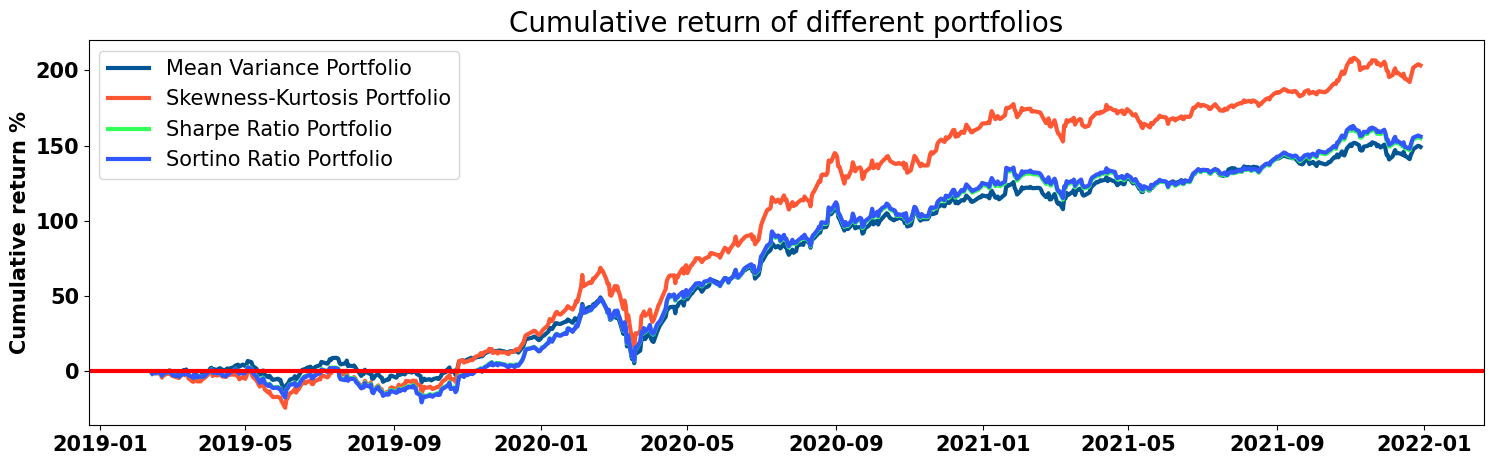

In [ ]:
#Testing the perfomance on the test data
import matplotlib.pyplot as plt


portfolio_return_test = np.multiply(test_data,np.transpose(res.x))
portfolio_return_test = portfolio_return_test.sum(axis=1)

#for sk
optimal_portfolio_return_sk=np.multiply(test_data,np.transpose(optimalsk_portfolio_weights))
optimal_portfolio_return_sk=optimal_portfolio_return_sk.sum(axis=1)

#for sharpe ratio
optimal_portfolio_return_sr = np.multiply(test_data,np.transpose(optimalsr_portfolio_weights))
optimal_portfolio_return_sr = optimal_portfolio_return_sr.sum(axis=1)

#for sortino
optimal_portfolio_return_st = np.multiply(test_data,np.transpose(optimalst_portfolio_weights))
optimal_portfolio_return_st = optimal_portfolio_return_st.sum(axis=1)

# Plot the cumulative returns for all portfolios
plt.figure(figsize=(18, 5))
plt.plot(np.cumsum(portfolio_return_test) * 100, label='Mean Variance Portfolio', color="#035593", linewidth=3)
plt.plot(np.cumsum(optimal_portfolio_return_sk) * 100, label='Skewness-Kurtosis Portfolio', color="#FF5733", linewidth=3)
plt.plot(np.cumsum(optimal_portfolio_return_sr) * 100, label='Sharpe Ratio Portfolio', color="#33FF57", linewidth=3)
plt.plot(np.cumsum(optimal_portfolio_return_st) * 100, label='Sortino Ratio Portfolio', color="#3357FF", linewidth=3)

# Add labels and title
plt.ylabel("Cumulative return %", size=15, fontweight="bold")
plt.xticks(size=15, fontweight="bold")
plt.yticks(size=15, fontweight="bold")
plt.title("Cumulative return of different portfolios", size=20)
plt.axhline(0, color="r", linewidth=3)

# Add legend
plt.legend(fontsize=15)

# Show plot
plt.show()